Balogh Szilárd, Băjan Ramona-Maria, Popa Sebastian

In [85]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from itertools import combinations
from memory_profiler import memory_usage
import seaborn as sns

In [86]:
def load_dataset(file_path):
    transactions = []
    with open(file_path, 'r') as file:
        for line in file:
            transactions.append(list(map(int, line.strip().split())))
    return transactions

In [87]:
def transactions_to_binary_matrix(transactions):
    """Converts transactions into a binary matrix for Apriori processing."""
    unique_items = sorted(set(item for trans in transactions for item in trans))
    item_to_index = {item: i for i, item in enumerate(unique_items)}
    
    binary_matrix = np.zeros((len(transactions), len(unique_items)), dtype=int)
    for i, trans in enumerate(transactions):
        for item in trans:
            binary_matrix[i][item_to_index[item]] = 1

    return binary_matrix, unique_items

In [88]:
def generate_rules(frequent_itemsets, min_confidence, num_transactions):
    """Generates association rules from frequent itemsets."""
    rules = []
    for itemset, support in frequent_itemsets.items():
        if len(itemset) < 2:
            continue
        
        for k in range(1, len(itemset)):  # Create subsets
            for antecedent in combinations(itemset, k):
                antecedent = set(antecedent)
                consequent = itemset - antecedent

                # Calculate confidence: P(Y|X) = support(X ∪ Y) / support(X)
                support_antecedent = frequent_itemsets.get(frozenset(antecedent), 0) / num_transactions
                confidence = (support / num_transactions) / support_antecedent if support_antecedent > 0 else 0

                if confidence >= min_confidence:
                    # Calculate interestingness measures
                    support_consequent = frequent_itemsets.get(frozenset(consequent), 0) / num_transactions
                    lift = confidence / support_consequent if support_consequent > 0 else 0
                    leverage = (support / num_transactions) - (support_antecedent * support_consequent)
                    conviction = (1 - support_consequent) / (1 - confidence) if confidence < 1 else np.inf

                    rules.append({
                        "Antecedent": antecedent,
                        "Consequent": consequent,
                        "Support": support / num_transactions,
                        "Confidence": confidence,
                        "Lift": lift,
                        "Leverage": leverage,
                        "Conviction": conviction
                    })
    return rules

In [89]:
def create_candidates(frequent_itemsets, k):
    candidates = set()
    itemsets_list = list(map(sorted, frequent_itemsets))  # Sort items to ensure the order

    for i in range(len(itemsets_list)):
        for j in range(i + 1, len(itemsets_list)):
            # Check if the first k-2 items are the same
            if itemsets_list[i][:-1] == itemsets_list[j][:-1]:
                # Join the two itemsets
                candidate_set = set(itemsets_list[i]).union(set(itemsets_list[j]))
                if len(candidate_set) == k:
                    candidates.add(tuple(sorted(candidate_set)))
    
    return candidates

def apriori_using_indices(matrix: np.ndarray, min_support, verbose=False):
    num_transactions, num_items = matrix.shape

    # Step 1: Count the support for each individual item (using indices)
    support = matrix.sum(axis=0)
    single_items = {index: support[index] for index in range(num_items)}

    if verbose:
        print(f"1-itemsets: {single_items}")

    # Step 2: Remove items below min_support
    single_items = {k: v for k, v in single_items.items() if v >= min_support}

    # Convert frequent single items to a list of sets containing indices
    frequent_itemsets = [tuple([index]) for index in single_items.keys()]

    if verbose:
        print(f"1-itemsets above min_support: {len(frequent_itemsets)}")

    all_frequent_itemsets = []
    all_frequent_itemsets.extend(frequent_itemsets)

    k = 2
    while frequent_itemsets:
        # Step 3: Generate candidate itemsets of length k using indices
        candidates = create_candidates(frequent_itemsets, k)

        # Step 4: Count support of candidates using the binary matrix
        candidate_support_counts = {candidate: 0 for candidate in candidates}

        for candidate in candidates:
            # Create a mask for rows that contain the candidate itemset
            indices = list(candidate)
            mask = matrix[:, indices].all(axis=1)  # All items must be present

            # Count how many transactions contain the candidate itemset
            candidate_support_counts[candidate] = np.sum(mask)

        if verbose:
            print(f"{k}-itemsets candidates: {len(candidate_support_counts)}")

        # Step 5: Prune non-frequent itemsets
        frequent_itemsets = [c for c, count in candidate_support_counts.items() if count >= min_support]

        if verbose:
            print(f"{k}-itemsets above min_support: {len(frequent_itemsets)}")
        all_frequent_itemsets.extend(frequent_itemsets)

        # Step 6: Move to the next level
        k += 1

    return all_frequent_itemsets

In [90]:
def evaluate_apriori(matrix, min_support, min_confidence):
    """Runs the Apriori algorithm and generates association rules efficiently."""
    start_time = time.time()
    
    # Capture both result and memory usage in one call
    mem_usage, frequent_itemsets_list = memory_usage(
        (apriori_using_indices, (matrix, min_support)), retval=True
    )
    
    num_transactions = matrix.shape[0]

    # Convert list of tuples to a dictionary for fast lookup
    frequent_itemsets = {
        frozenset(itemset): matrix[:, list(itemset)].all(axis=1).sum() 
        for itemset in frequent_itemsets_list
    }

    rules = generate_rules(frequent_itemsets, min_confidence, num_transactions)

    end_time = time.time()
    runtime = end_time - start_time

    return frequent_itemsets, rules, runtime, max(mem_usage)


In [91]:
def plot_statistics(transactions, binary_matrix, unique_items):
    """Plots item frequency and transaction size distribution with proper labels."""
    item_counts = binary_matrix.sum(axis=0)
    sorted_indices = np.argsort(-item_counts)  # Sort by frequency (descending)
    
    sorted_items = [unique_items[idx] for idx in sorted_indices[:20]]  # Get actual item names
    sorted_counts = item_counts[sorted_indices[:20]]

    plt.figure(figsize=(12, 6))
    sns.barplot(x=sorted_items, y=sorted_counts, palette="Blues_r")
    plt.xlabel("Item Value")
    plt.ylabel("Occurrence Count")
    plt.title("Top 20 Frequent Items")
    plt.xticks(rotation=90)
    plt.show()

    transaction_sizes = binary_matrix.sum(axis=1)
    plt.figure(figsize=(10, 5))
    sns.histplot(transaction_sizes, bins=20, kde=True)
    plt.xlabel("Transaction Size")
    plt.ylabel("Frequency")
    plt.title("Transaction Size Distribution")
    plt.show()


Processing chess.dat.txt...



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20504\2557448358.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_items, y=sorted_counts, palette="Blues_r")


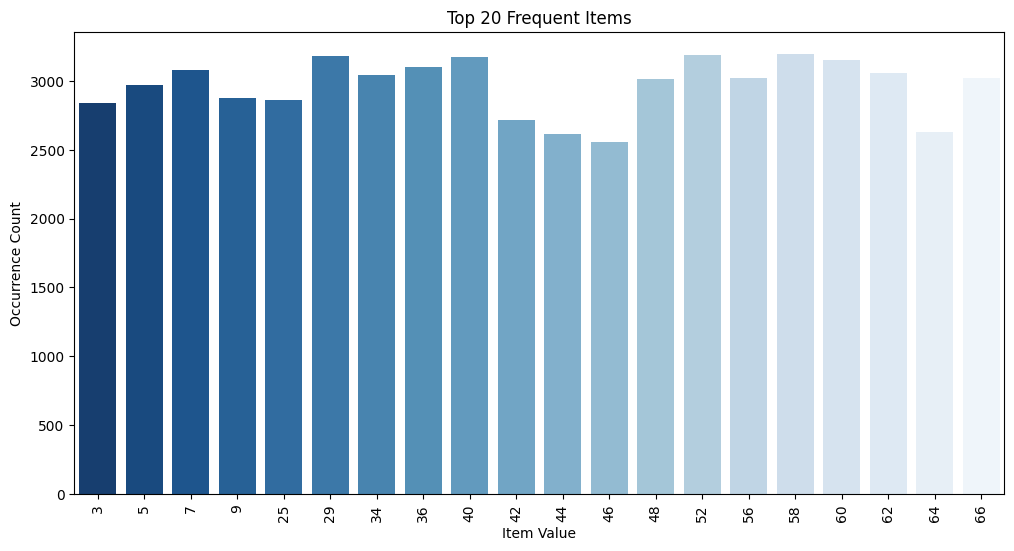

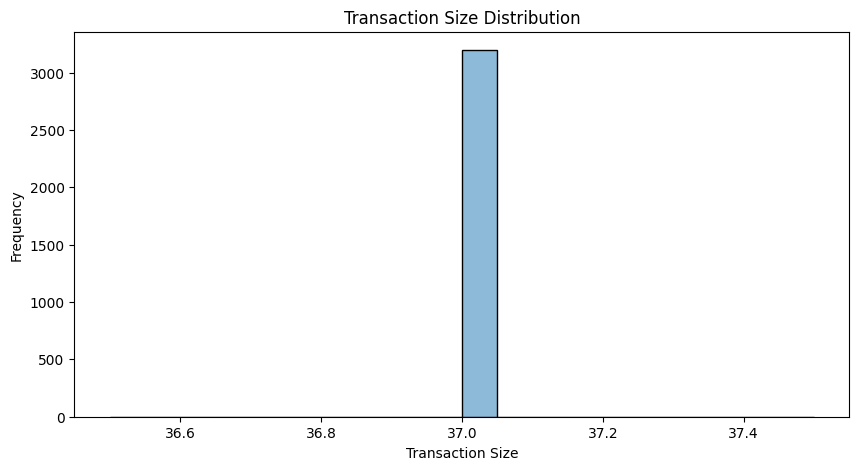

Runtime: 1.5109 sec | Max Memory: 242.12 MB
Frequent Itemsets (Top 10):
[(frozenset({58}), np.int64(3195)), (frozenset({52}), np.int64(3185)), (frozenset({58, 52}), np.int64(3184)), (frozenset({29}), np.int64(3181)), (frozenset({58, 29}), np.int64(3180)), (frozenset({40}), np.int64(3170)), (frozenset({52, 29}), np.int64(3170)), (frozenset({40, 58}), np.int64(3169)), (frozenset({58, 52, 29}), np.int64(3169)), (frozenset({40, 52}), np.int64(3159))]

Association Rules (Top 10):
frozenset({58}) → frozenset({52}) | Support: 0.996 | Confidence: 0.997 | Lift: 1.000 | Leverage: -0.000 | Conviction: 1.000
frozenset({52}) → frozenset({58}) | Support: 0.996 | Confidence: 1.000 | Lift: 1.000 | Leverage: -0.000 | Conviction: 0.997
frozenset({58}) → frozenset({29}) | Support: 0.995 | Confidence: 0.995 | Lift: 1.000 | Leverage: -0.000 | Conviction: 1.000
frozenset({29}) → frozenset({58}) | Support: 0.995 | Confidence: 1.000 | Lift: 1.000 | Leverage: -0.000 | Conviction: 0.995
frozenset({52}) → frozen

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20504\2557448358.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_items, y=sorted_counts, palette="Blues_r")


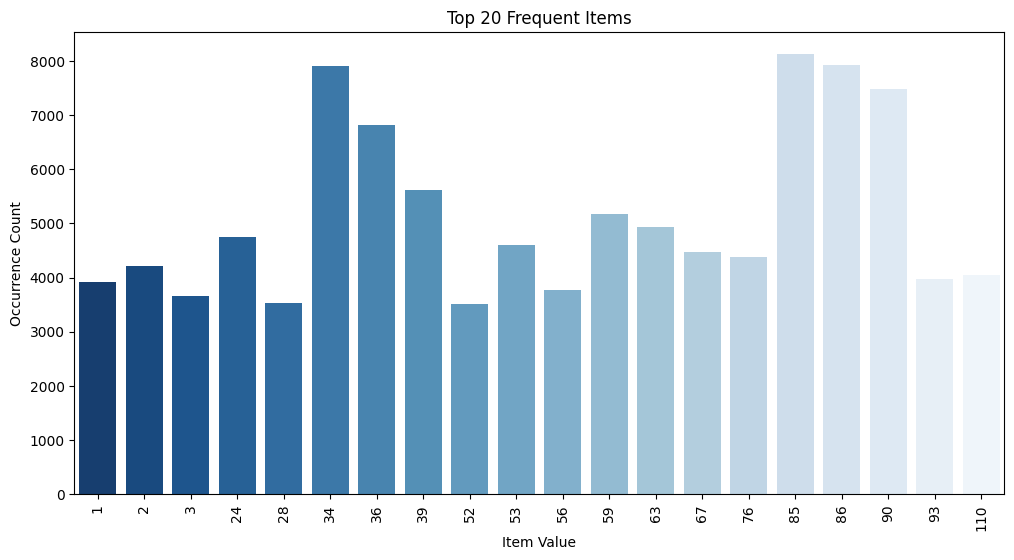

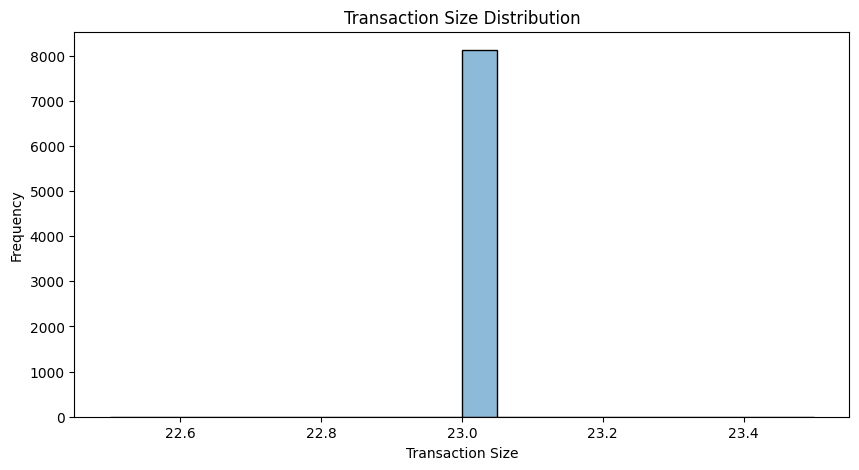

Runtime: 2.5668 sec | Max Memory: 231.93 MB
Frequent Itemsets (Top 10):
[(frozenset({85}), np.int64(8124)), (frozenset({86}), np.int64(7924)), (frozenset({85, 86}), np.int64(7924)), (frozenset({34}), np.int64(7914)), (frozenset({34, 85}), np.int64(7914)), (frozenset({34, 86}), np.int64(7906)), (frozenset({34, 85, 86}), np.int64(7906)), (frozenset({90}), np.int64(7488)), (frozenset({90, 85}), np.int64(7488)), (frozenset({90, 34}), np.int64(7296))]

Association Rules (Top 10):
frozenset({85}) → frozenset({86}) | Support: 0.975 | Confidence: 0.975 | Lift: 1.000 | Leverage: 0.000 | Conviction: 1.000
frozenset({86}) → frozenset({85}) | Support: 0.975 | Confidence: 1.000 | Lift: 1.000 | Leverage: 0.000 | Conviction: inf
frozenset({34}) → frozenset({85}) | Support: 0.974 | Confidence: 1.000 | Lift: 1.000 | Leverage: 0.000 | Conviction: inf
frozenset({85}) → frozenset({34}) | Support: 0.974 | Confidence: 0.974 | Lift: 1.000 | Leverage: 0.000 | Conviction: 1.000
frozenset({34}) → frozenset({86}

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20504\2557448358.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_items, y=sorted_counts, palette="Blues_r")


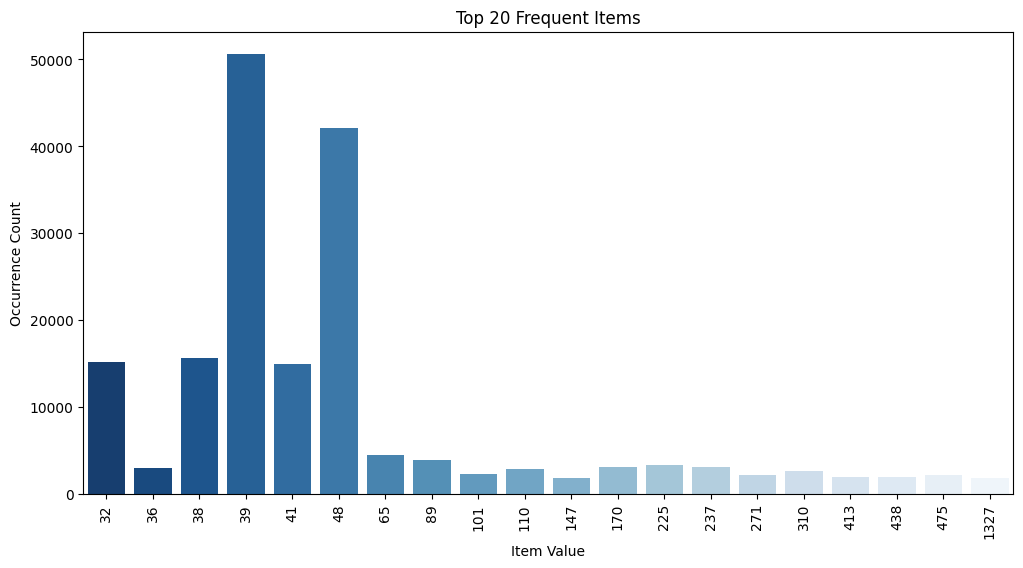

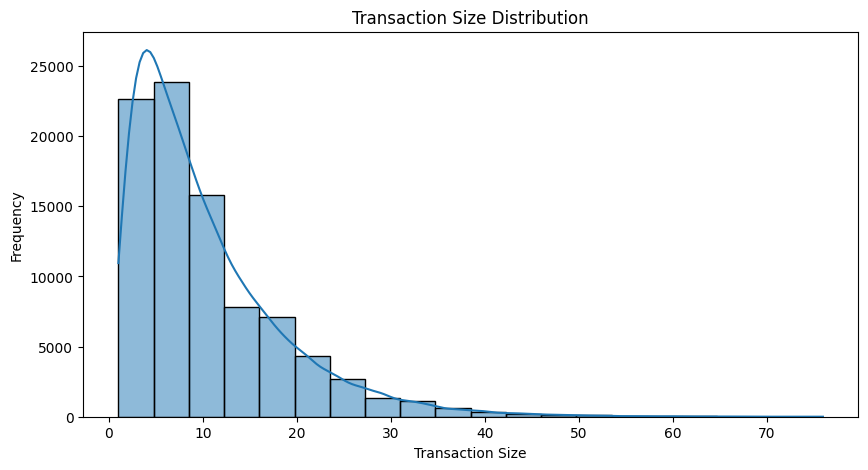

Runtime: 1.8734 sec | Max Memory: 11324.33 MB
Frequent Itemsets (Top 10):
[(frozenset({39}), np.int64(50675)), (frozenset({48}), np.int64(42135)), (frozenset({48, 39}), np.int64(29142)), (frozenset({38}), np.int64(15596)), (frozenset({32}), np.int64(15167)), (frozenset({41}), np.int64(14945)), (frozenset({41, 39}), np.int64(11414)), (frozenset({38, 39}), np.int64(10345)), (frozenset({48, 41}), np.int64(9018))]

Association Rules (Top 10):
frozenset({48}) → frozenset({39}) | Support: 0.331 | Confidence: 0.692 | Lift: 1.203 | Leverage: 0.056 | Conviction: 1.379
frozenset({39}) → frozenset({48}) | Support: 0.331 | Confidence: 0.575 | Lift: 1.203 | Leverage: 0.056 | Conviction: 1.229
frozenset({41}) → frozenset({39}) | Support: 0.129 | Confidence: 0.764 | Lift: 1.329 | Leverage: 0.032 | Conviction: 1.800
frozenset({39}) → frozenset({41}) | Support: 0.129 | Confidence: 0.225 | Lift: 1.329 | Leverage: 0.032 | Conviction: 1.072
frozenset({38}) → frozenset({39}) | Support: 0.117 | Confidence: 

In [ ]:
def process_apriori(file, min_support_ratio, min_confidence):
    print(f"\nProcessing {file}...\n")
    # Load the dataset
    transactions = load_dataset(file)

    # Convert transactions to binary matrix
    binary_matrix, unique_items = transactions_to_binary_matrix(transactions)

    # Create mapping dictionaries
    item_to_index = {item: idx for idx, item in enumerate(unique_items)}
    index_to_item = {idx: item for item, idx in item_to_index.items()}

    # Calculate minimum support
    min_support = min_support_ratio * binary_matrix.shape[0]

    # Plot statistics
    plot_statistics(transactions, binary_matrix, unique_items)

    # Run Apriori algorithm
    frequent_itemsets, rules, runtime, mem_usage = evaluate_apriori(binary_matrix, min_support, min_confidence)

    # Convert frequent itemsets back to original item values
    frequent_itemsets_mapped = {
        frozenset(index_to_item[idx] for idx in itemset): support
        for itemset, support in frequent_itemsets.items()
    }

    # Sort frequent itemsets by support in descending order
    sorted_frequent_itemsets = sorted(
        frequent_itemsets_mapped.items(),
        key=lambda x: x[1],  # Sort by the support value
        reverse=True         # Ensure descending order
    )

    # Convert rules back to original item values
    rules_mapped = [
        {
            'Antecedent': frozenset(index_to_item[idx] for idx in rule['Antecedent']),
            'Consequent': frozenset(index_to_item[idx] for idx in rule['Consequent']),
            'Support': rule['Support'],
            'Confidence': rule['Confidence'],
            'Lift': rule['Lift'],
            'Leverage': rule['Leverage'],
            'Conviction': rule['Conviction']
        }
        for rule in rules
    ]

    # Sort rules by Support in descending order
    sorted_rules = sorted(
        rules_mapped,
        key=lambda rule: rule['Support'],  # Sort by the 'Support' attribute
        reverse=True  # Ensure descending order
    )

    # Output results
    print(f"Runtime: {runtime:.4f} sec | Max Memory: {mem_usage:.2f} MB")
    print(f"Frequent Itemsets (Top 10):\n{sorted_frequent_itemsets[:10]}")

    print("\nAssociation Rules (Top 10):")
    for rule in sorted_rules[:10]:
        print(f"{rule['Antecedent']} → {rule['Consequent']} | "
              f"Support: {rule['Support']:.3f} | Confidence: {rule['Confidence']:.3f} | "
              f"Lift: {rule['Lift']:.3f} | Leverage: {rule['Leverage']:.3f} | "
              f"Conviction: {rule['Conviction']:.3f}")

process_apriori("chess.dat.txt", 0.85, 0.7)
process_apriori("mushroom.dat.txt", 0.85, 0.7)
process_apriori("retail.dat.txt", 0.1, 0.1)

During our testing we have observed that in order for the algorithm to finish in a reasonable time for the chess and mushroom datasets, we must set the value for min_support_ratio to a very high value (at least 0.85) due to the exponential growth of candidate itemsets at higher values of 𝑘. For instance, for the chess dataset, we tried setting min_support_ratio to 0.5, which got stuck at 𝑘 = 5. We tried debugging the algorithm and we saw that at that 𝑘 value, the number of candidate itemsets was 74618 (we let the algorithm run for 10 minutes, after we stopped it). By setting the min_support_ratio to 0.85 and min_confidence to 0.70, we made the following observations: for the chess dataset we obtained a runtime of 1.5109 sec and a max memory usage of 242.12 MB. In this dataset, the lines are mostly identical, which explains the results we got: there are some pairs with very high support and confidence, which, however, have lift = 1, leverage = 0 and conviction about equal to 1. For example, our association rule with the greatest support is: ({58}) → ({52}) | Support: 0.996 | Confidence: 0.997 | Lift: 1.000 | Leverage: -0.000 | Conviction: 1.000. This means that even though 58 and 52 appear a lot of times in the same transaction, the fact that they appear together is purely by chance.

In the mushroom dataset the lines are slightly more divers, which leads to some more interesting results. For example, in the association rule {86} -> {85} the conviction is 'inf', which means that every time 86 appears, 85 will appear as well. Moreover, we have association rules like: 'frozenset({34}) → frozenset({86}) | Support: 0.973 | Confidence: 0.999 | Lift: 1.024 | Leverage: 0.023 | Conviction: 24.354'. This example describes the following: out of all the transitions, about 97% contain both 34 and 86, if in a transition 34 appears, there is an approximately 99% chance, that 86 will appear as well. Since lift is greater than 1, it entails a positive association. Similarly, the leverage of 0.023 means that the two items are somewhat more likely to occur together than by pure chance. Conviction measures how strongly the absence of the consequent (in this case, 86) depends on the antecedent (34). A conviction of 24.354 is relatively high and implies that the rule has good predictive power for item 86 when 34 is present. This means that seeing 34 in a transaction makes it significantly less likely that 86 will be absent.

As for the third dataset we used, retail.txt, this is the only one out of the 3 that has different transition sizes and the lines are completely different from one another. Therefore, we can (and should) set min_support_ratio to a much smaller value, because the number of itemsets won't be as great as it is for those datasets in which almost the same lines get repeated. For this dataset, our association rule with the highest support is frozenset({48}) → frozenset({39}) | Support: 0.331 | Confidence: 0.692 | Lift: 1.203 | Leverage: 0.056 | Conviction: 1.379. From the lift value we can deduce that the appearence of the item 48 increases by about 20% the likelihood that the item 39 will appear as well, with both leverage and conviction showing a positive association between these 2 items.